# Production Model
---
Using the best model found during model tuning I'm going to better visualize it's performance.

In [73]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier, StackingClassifier)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (f1_score, ConfusionMatrixDisplay, confusion_matrix,
                             RocCurveDisplay, balanced_accuracy_score)

In [3]:
# read data in
combined = pd.read_csv("../data/combined_subreddits.csv")

# lemmatize titles and posts
combined = combined.map(lambda x: word_tokenize(x.lower()))

lem = WordNetLemmatizer()
combined = combined.map(lambda x: " ".join([lem.lemmatize(i) for i in x]))

# create interaction column
combined["title_and_post"] = combined["title"] + " " + combined["post"]

# binarize target subreddit column 
combined["subreddit"] = combined["subreddit"].map({"fantasy": 0, "scifi": 1})

In [4]:
# X and y
X = combined["title_and_post"]
y = combined["subreddit"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [20]:
# StackingClassifier model utilizing LogisticRegression,
# RandomForestClassifier, and AdaBoostClassifier all with CountVectorization
level1_models = [
    ("logr_pipe", Pipeline([
        ("cvec", CountVectorizer(stop_words="english", max_df=0.9,
                                 min_df=8, max_features=1500, ngram_range=(1, 3))),
        ("ss", StandardScaler(with_mean=False)),
        ("logr", LogisticRegression(penalty="l1", solver="liblinear", random_state=42))
    ])),
    ("rf_pipe", Pipeline([
        ("cvec", CountVectorizer(stop_words="english", max_df=0.9,
                                 min_df=6, max_features=1400, ngram_range=(1, 2))),
        ("rf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])),
    ("ada_pipe", Pipeline([
        ("cvec", CountVectorizer(stop_words="english", max_features=1800)),
        ("ada", AdaBoostClassifier(n_estimators=200, algorithm="SAMME", random_state=42))
        # uses SAMME algorithm to avoid future warning this time
    ]))
]

stacked_model = StackingClassifier(estimators=level1_models,
                final_estimator=LogisticRegression(penalty="l1", solver="liblinear", random_state=42))

stacked_model.fit(X_train, y_train)

StackingClassifier(estimators=[('logr_pipe',
                                Pipeline(steps=[('cvec',
                                                 CountVectorizer(max_df=0.9,
                                                                 max_features=1500,
                                                                 min_df=8,
                                                                 ngram_range=(1,
                                                                              3),
                                                                 stop_words='english')),
                                                ('ss',
                                                 StandardScaler(with_mean=False)),
                                                ('logr',
                                                 LogisticRegression(penalty='l1',
                                                                    random_state=42,
                                                                    solver='liblinear'))])),
                               ('rf_pipe',
                                Pipeline(steps=[('cvec',
                                                 CountVectorizer(max_df=0.9,
                                                                 max_fe...
                                                                 stop_words='english')),
                                                ('rf',
                                                 RandomForestClassifier(n_estimators=150,
                                                                        random_state=42))])),
                               ('ada_pipe',
                                Pipeline(steps=[('cvec',
                                                 CountVectorizer(max_features=1800,
                                                                 stop_words='english')),
                                                ('ada',
                                                 AdaBoostClassifier(algorithm='SAMME',
                                                                    n_estimators=200,
                                                                    random_state=42))]))],
                   final_estimator=LogisticRegression(penalty='l1',
                                                      random_state=42,
                                                      solver='liblinear'))

In [21]:
# See accuracy and F1 score again, also see balanced accuracy
print(f"Training Accuracy : {stacked_model.score(X_train, y_train)}")
print(f"Testing Accuracy : {stacked_model.score(X_test, y_test)}")
print(f"Balanced Accuracy : {balanced_accuracy_score(y_test, stacked_model.predict(X_test))}")
print(f"F1 Score : {f1_score(y_test, stacked_model.predict(X_test))}")

Training Accuracy : 0.9972054028877504
Testing Accuracy : 0.9203910614525139
Balanced Accuracy : 0.9208888609504652
F1 Score : 0.9256844850065189


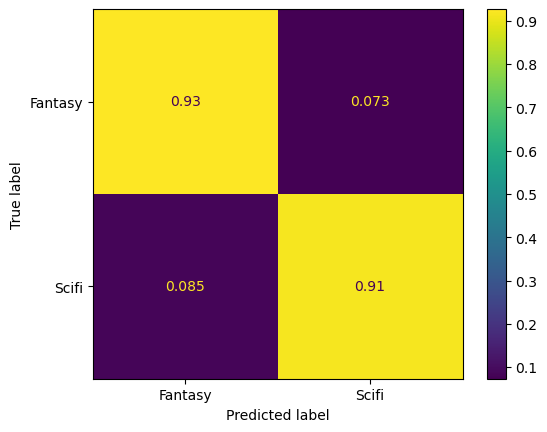

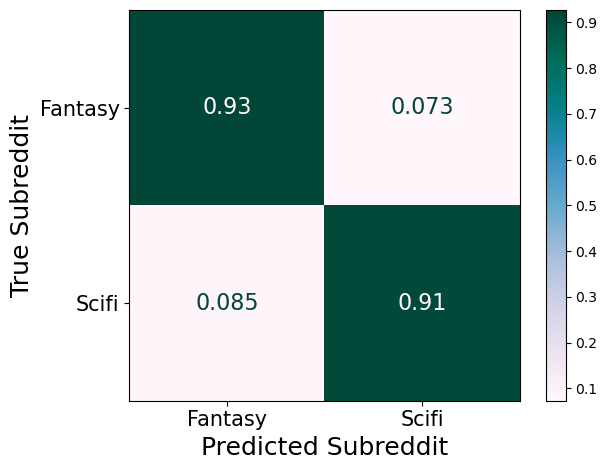

In [88]:
# create confusion matrix
# method to change size of annotations found using Google AI
cm = confusion_matrix(y_test, stacked_model.predict(X_test))
disp = ConfusionMatrixDisplay.from_estimator(stacked_model, X_test, y_test,
                                           display_labels=["Fantasy", "Scifi"],
                                           normalize="true")
disp.plot(cmap="PuBuGn")
ax = disp.ax_
for text in ax.texts:
    text.set_fontsize(16)
plt.xlabel("Predicted Subreddit", size=18)
plt.ylabel("True Subreddit", size = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
# just saving image with larger font size for presentation slides
plt.savefig("../images/confusion_matrix.png");

*We can visualize here what the F1 score has been demonstrating, this model is doing well with both classes, not overly producing false positives or false negatives.*

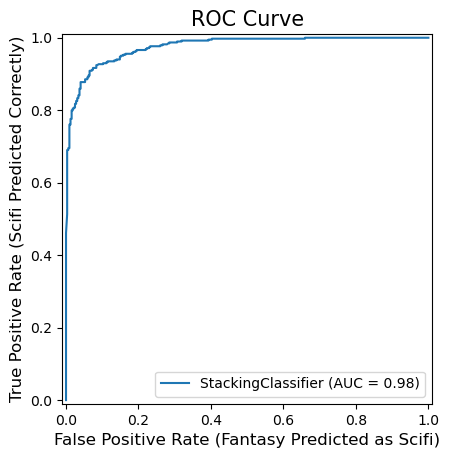

In [58]:
# generate roc curve
RocCurveDisplay.from_estimator(stacked_model, X_test, y_test)
plt.title("ROC Curve", size=15)
plt.xlabel("False Positive Rate (Fantasy Predicted as Scifi)", size=12)
plt.ylabel("True Positive Rate (Scifi Predicted Correctly)", size =12);

*This model has a very good AUC of 0.98.*

---
## Conclusion and Insights


My production model here is overfit, but still has an accuracy of 92.04% and F1 score of 92.57%, meaning it's pretty balanced for accurately predicting both subreddits. The goal was to see how accurate I could make a model because the misclassification, about 8%, represents the small potential interest in a crossover genre between fantasy and science fiction. I would also recommend someone wanting to write a story in either genre would have better luck with fantasy, and if the writer's interest is more in science fantasy then consider writing a screen play since there seemed to be more interest in science fiction movies than novels.